# Applications!
In this ipynb file, we will show you how to apply **MDAnalysis** to calcultate time averaged properties of the radial distribution function (RDF).

Reference: https://userguide.mdanalysis.org/1.1.1/examples/analysis/custom_parallel_analysis.html

In [1]:
import MDAnalysis as mda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openmm.app import PDBxFile
from openmm.app import PDBFile
from openmm.app import ForceField
import time
import sys
import os

In [2]:
# import library files
sys.path.append('./lib')
from mylib import rdf_self, rdf, center
from QfromFF import QfromFF

In [3]:
# Multiprocess packages
import multiprocessing
from multiprocessing import Pool
from functools import partial

In [4]:
# Topology files
topfile='./example_files/md_nvt_last.cif'

# Position files that contain trajectories of simulation
posfile='./example_files/md_nvt.dcd'

In [5]:
# Create universe object
u = mda.Universe(PDBxFile(topfile),posfile, dt=10000)

# MDAnalysis do not support the reading cif (extended PDB file) formatted files.
# Here, we utilize the openmm.app.PDBxFile reader function to load topology informations.
# For PDBFile you can use it directly as follows,
# u = mda.Universe(topfile,posfile,dt=10000)

/home/ph/Programs/miniconda3/envs/omm_8.3/lib/python3.13/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [6]:
# Force field file in OpenMM
fieldfile="./example_files/field_q08.xml"
ff=ForceField(fieldfile)

# Set-up charges from force field file
QfromFF(u,ff)

c4c c4c1pyrr+
tf2 tf2N-
{'c4c': 'c4c1pyrr+', 'tf2': 'tf2N-'}


In [7]:
def rdf_per_frame(frame_index, atomgroup1, atomgroup2, bin):
    """
    frame_index : target frame index
    atomgroup1 : atom group objects
    atomgroup2 : ...
    bin : bin size for the calculation of radial distribution function (unit: Angstrom)

    If, atomgroup1 == atomgroup2, rdf_self subroutine will be used.
    Else, rdf subroutine will be used.

    Here, we used the center of charges for the definition of COM.
    Therefore, before using this functions all the partial charges should be set-up
    by QfromFF function.

    return value histo is the 1-D array with dimension (4000)
    caution: histo array is yet normalzied by 4 pi r^2
    
    """
    
    # index the trajectory to set it to the frame_index frame
    atomgroup1.universe.trajectory[frame_index]

    # coordinates change for each frame
    box1 = atomgroup1.dimensions
    box2 = atomgroup2.dimensions
    assert (box1==box2).all()

    if ( atomgroup1 == atomgroup2 ):
        res1_ids=list(set(atomgroup1.resids))
        res1_masses=u.select_atoms(f'resid {res1_ids[0]}').charges
        pos1 = center( atomgroup1.positions, res1_masses , len(res1_ids) )
        histo = rdf_self(pos1, box1, bin)

    else:
        res1_ids=list(set(atomgroup1.resids))
        res1_masses=u.select_atoms(f'resid {res1_ids[0]}').charges
        pos1 = center( atomgroup1.positions, res1_masses , len(res1_ids) )

        res2_ids=list(set(atomgroup2.resids))
        res2_masses=u.select_atoms(f'resid {res2_ids[0]}').charges
        pos2 = center( atomgroup2.positions, res2_masses , len(res2_ids) )

        histo = rdf(pos1, pos2, box1, bin)

    #print('pid : %d' %(os.getpid()))
    #print("   ",pos1[0], ag1.positions[0])
    return histo

0.71647sec


(0.0, 2.5)

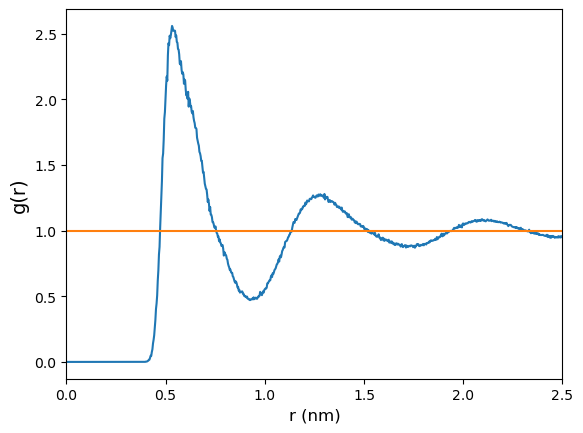

In [10]:
# Calculation of radial distribution function 
# between cations and anions for the first trajectory.

ag1 = u.select_atoms(f'resname c4c')
ag2 = u.select_atoms(f'resname tf2')

run_per_frame = partial(rdf_per_frame,
                        atomgroup1=ag1,
                        atomgroup2=ag2,
                        bin=0.03)

# Calculate RDF using multiprocess
frame_values = np.arange(u.trajectory.n_frames)
n_jobs = 4

start=time.time()
with Pool(n_jobs) as worker_pool:
    result = worker_pool.map(run_per_frame, frame_values)
end=time.time()

print(f"{end-start:.5f}sec")

ntraj=len(frame_values)
averaged=np.sum(result, axis=0)/np.float64(ntraj)

r =[]
for ibin in range(1,4001):
    r.append( (ibin-0.5)*0.03/10 ) # Angstrom to nanometer 

plt.plot(r,averaged)
plt.plot(r,[1]*4000)

plt.xlabel("r (nm)", fontsize=12)
plt.ylabel("g(r)", fontsize=14)

plt.xlim(0,2.5)